# Lesson 2. Visualizing NCEP's High-Resolution Rapid Refresh (HRRR) model 2-meter temperatures

**Objectives**:
1. Learn what is `Zarr` and its foundational principles
2. Access archived NCEP HRRR data hosted on AWS S3 in `Zarr` format
3. Visualize one of the variables (2m temperature) at a specific point in time

## What is Zarr?

<img src="img/zarr_logo_horizontal.svg" width="30%" alt="zarr_logo_horizontal.svg">

`Zarr` is an open-source specification and library for storing large, multi-dimensional typed arrays (tensors) in chunked, compressed formats, optimized for cloud object storage. It enables efficient parallel I/O, allowing concurrent reads and writes, making it ideal for large-scale scientific data analysis. Zarr is often described as a "cloud-native" alternative to older formats like HDF5. 

Gridded datasets, especially those produced by operational meteorological centers such as NCEP and ECMWF, are typically in NetCDF and GRIB formats. Zarr is a relatively new data format. It is particularly relevant in the following two scenarios:
1. Datasets that are stored in what's called *object store*. This is a commonly-used storage method for cloud providers, such as Amazon, Google, and Microsoft.
2. Datasets that are typically too large to load into memory all at once.

`Xarray` supports the Zarr format in addition to NetCDF and GRIB. The [Pangeo](https://pangeo.io) project specifically recommends Zarr as the Xarray-amenable data format of choice in the cloud. 

## How is data stored in Zarr?

<img src="img/zarr_diagram.png" width="25%" alt="zarr_diagram">

Key features and details about `Zarr` include:

- **Cloud-Native Design**: Zarr is specifically designed to work efficiently with object stores like AWS S3, Google Cloud Storage, and Azure Blob Storage.
- **Chunked Storage**: Data is divided into smaller chunks, allowing only necessary portions to be loaded into memory, which improves performance for large datasets.
- **Compression**: Chunks are individually compressed, optimizing storage space.
- **Interoperability**: It is used across various languages, including Python, Julia, Java, C++, and Rust.
- **Structure**: It uses a directory-like hierarchy to store metadata (in JSON) and data (as binary files).
- **Use Cases**: It is widely used for high-dimensional scientific data, such as neuroimaging, climate science, and bioimaging. 

### Data Organization

The `Zarr` data specification organizes data as a hierarchical structure that mirrors the shape and organization of your arrays. Here’s a quick breakdown of how the data is stored (based on the Zarr V3 storage specification):

`Zarr` separates where data is stored from how it’s organized, using two key concepts: **stores** and **groups**.

A **Store** is the backend that defines where the data physically lives. A Zarr store can be:

- A directory on disk (e.g., LocalStore)
- A cloud bucket (e.g., FsspecStore for s3://…)
- An in-memory dictionary (e.g., MemoryStore)
- A custom system like Icechunk (covered below)

A **Group** is a logical container for organizing data, like folders in a file system. 

- A group can contain multiple related Zarr arrays
- It can also hold other groups (nested hierarchy)
- Each group has its own metadata (in zarr.json)
- Groups live within a store

If you want to read more details, please refer to [this blog post by Earthmover](https://earthmover.io/blog/what-is-zarr/).

### Step 1. Load the necessary libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import s3fs
import metpy
from importlib.metadata import version
import warnings #dont print warnings
warnings.filterwarnings('ignore')

### Step 2. Access archived NCEP HRRR data hosted on AWS in `Zarr` format

For a number of years, the [Mesowest](https://mesowest.utah.edu/) group at the University of Utah has hosted an archive of data from NCEP's High Resolution Rapid Refresh model. This data, originally in GRIB-2 format, has been converted into Zarr and is freely available "in the cloud", on [Amazon Web Service's Simple Storage Service](https://aws.amazon.com/s3/), otherwise known as **S3**. Data is stored in S3 in a manner akin to (but different from) a Linux filesystem, using a [*bucket* and *object*](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html#CoreConcepts) model.

To interactively browse the contents of this archive, go to this link: [HRRRZarr File Browser on AWS](https://hrrrzarr.s3.amazonaws.com/index.html)

To access Zarr-formatted data stored in an S3 bucket, we follow a 3-step process:
1. Create URL(s) pointing to the bucket and object(s) that contain the data we want
1. Create *map(s)* to the object(s) with the **s3fs** library's `S3Map` method
1. Pass the *map(s)* to Xarray's `open_dataset` or `open_mfdataset` methods, and specify `zarr` as the format, via the `engine` argument.

<div class="alert alert-info">
A quirk in how these grids were converted from GRIB2 to Zarr means that the dimension variables are defined one directory up from where the data variables are. Thus, our strategy is to use Xarray's <code>open_mfdataset</code> method and pass in two AWS S3 file references to these two corresponding directories.
</div>

Create the URLs

In [2]:
date = '20210214'
hour = '12'
var = 'TMP'
level = '2m_above_ground'
url1 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_anl.zarr/' + level + '/' + var + '/' + level
url2 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_anl.zarr/' + level + '/' + var

<div class="alert alert-info">
    In this case, <b>hrrrzarr</b> is the S3 <i>bucket</i> name. <b>2m_above_ground</b> and <b>TMP</b> are both <i>objects</i> within the <b>bucket</b>. The former object has the 2-meter temperature array, while the latter contains the coordinate arrays of the spatial dimensions of 2m temperature (i.e., x and y).
</div>

Connect to the S3 object store. With the [release of Zarr version 3](https://zarr.readthedocs.io/en/latest/user-guide/v3_migration.html), the methods to do this have changed from version 2 (see, e.g. Zarr issues [2706](https://github.com/zarr-developers/zarr-python/issues/2706) and [2748](https://github.com/zarr-developers/zarr-python/issues/2748)) . Test which version is installed and use the appropriate methodology.

In [3]:
package = "zarr"
package_version = version(package)
major_version = int(package_version.split(".")[0])  # Extract the major version

if major_version == 3:      
    import zarr
    # strip leading 's3://' from url
    url1_3 = url1[5:]
    url2_3 = url2[5:]
    fs = s3fs.S3FileSystem(anon=True, asynchronous=True)
    file1 = zarr.storage.FsspecStore(fs, path=url1_3)
    file2 = zarr.storage.FsspecStore(fs, path=url2_3)
else:
    fs = s3fs.S3FileSystem(anon=True, asynchronous=False)
    file1 = s3fs.S3Map(url1, s3=fs)
    file2 = s3fs.S3Map(url2, s3=fs)

Use Xarray's `open_mfdataset` to create a `Dataset` from these two S3 objects.

In [4]:
ds = xr.open_mfdataset([file1,file2], engine='zarr')

Examine the dataset.

In [5]:
ds

<xarray.Dataset> Size: 4MB
Dimensions:                  (projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
Data variables:
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 4MB dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] 8B ...
    forecast_reference_time  datetime64[ns] 8B ...
    height                   float64 8B ...
    pressure                 float64 8B ...
    time                     datetime64[ns] 8B ...

Get the map projection for the HRRR, which is stored in the `grid` folder in the AWS bucket.

In [6]:
HRRR_proj = pd.read_json ("https://hrrrzarr.s3.amazonaws.com/grid/projparams.json", orient="index")
HRRR_proj

,0
a,6371229
b,6371229
proj,lcc
lon_0,262.5
lat_0,38.5
lat_1,38.5
lat_2,38.5


In [7]:
lat_0 = HRRR_proj.loc['lat_0'].astype('float32').squeeze()
lat_1 = HRRR_proj.loc['lat_1'].astype('float32').squeeze()
lat_2 = HRRR_proj.loc['lat_2'].astype('float32').squeeze()
lon_0 = HRRR_proj.loc['lon_0'].astype('float32').squeeze()
a = HRRR_proj.loc['a'].astype('float32').squeeze()
b = HRRR_proj.loc['b'].astype('float32').squeeze()

projData= ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0,
                                standard_parallels=[lat_1,lat_2],
                                globe=ccrs.Globe(semimajor_axis=a, semiminor_axis=b))

<div class="alert alert-warning"><b>Note: </b>
    The HRRR's projection assumes a <i>spherical earth</i>, whose semi-major/minor axes are both equal to 6371.229 km. We therefore need to explicitly define a <code>Globe</code> in Cartopy with these values.
</div>

Examine the dataset's coordinate variables. Each x- and y- value represents distance in meters from the central latitude and longitude.

In [8]:
ds.coords

Coordinates:
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...

Create an object pointing to the dataset's data variable.

In [9]:
airTemp = ds.TMP

When we examine the object, we see that it is a special type of `DataArray` ... a *[DaskArray](https://docs.dask.org/en/latest/array.html)*.

In [10]:
airTemp

<xarray.DataArray 'TMP' (projection_y_coordinate: 1059,
                         projection_x_coordinate: 1799)> Size: 4MB
dask.array<open_dataset-TMP, shape=(1059, 1799), dtype=float16, chunksize=(150, 150), chunktype=numpy.ndarray>
Coordinates:
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
Attributes:
    GRIB_PARAM:  [2, 0, 0, 0]
    long_name:   2m_above_ground/TMP
    units:       K

### Sidetrip: The `Dask` library

<div class="alert alert-info">Dask is a Python library that is especially well-suited for handling very large datasets (especially those that are too large to fit into RAM) and is nicely integrated with Xarray. We're going to defer a detailed exploration of Dask for now. But suffice it to say that when we use <code>open_mfdataset</code>, the resulting objects are <i>Dask</i> objects.
</div>

MetPy supports Dask arrays, and so performing a unit conversion is straightforward.

In [11]:
airTemp = airTemp.metpy.convert_units('degC')

Verify that the object has the unit change

In [12]:
airTemp

<xarray.DataArray 'TMP' (projection_y_coordinate: 1059,
                         projection_x_coordinate: 1799)> Size: 4MB
<Quantity(dask.array<truediv, shape=(1059, 1799), dtype=float16, chunksize=(150, 150), chunktype=numpy.ndarray>, 'degree_Celsius')>
Coordinates:
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
Attributes:
    GRIB_PARAM:  [2, 0, 0, 0]
    long_name:   2m_above_ground/TMP

Similar to what we did for datasets whose projection-related coordinates were latitude and longitude, we define objects pointing to x and y now, so we can pass them to the plotting functions.

In [13]:
x = airTemp.projection_x_coordinate
y = airTemp.projection_y_coordinate

### Step 3. Visualize 2m temperatures at a given point in time

First, just use Xarray's `plot` function to get a quick look to verify that things look right.

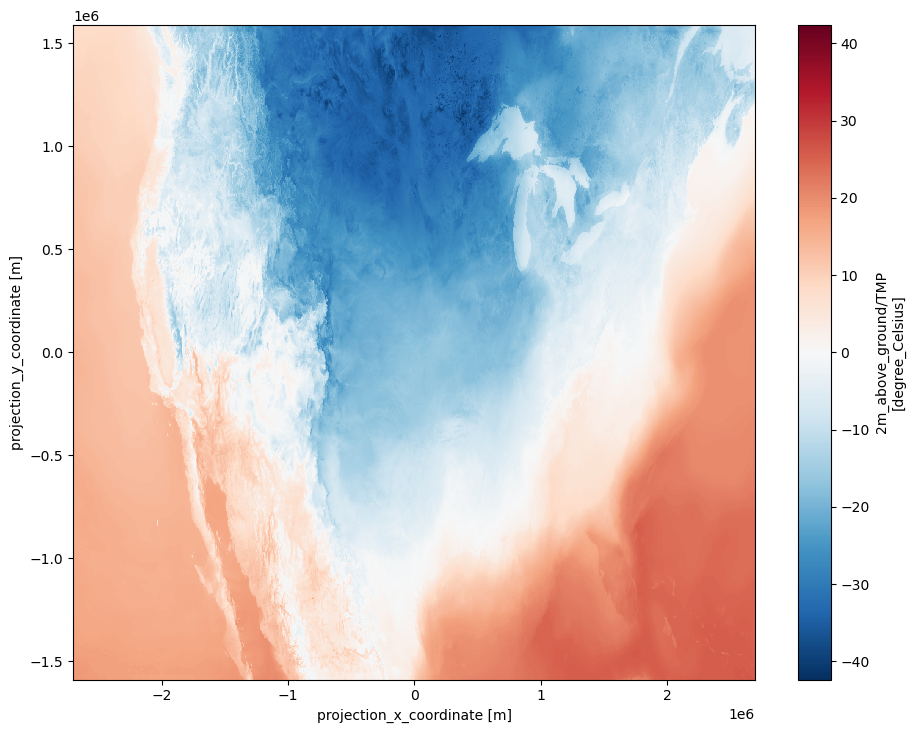

In [14]:
airTemp.plot(figsize=(11,8.5))

To facilitate the bounds of the contour intervals, obtain the min and max values from this `DataArray`.

<div class="alert alert-warning">
    A Dask array is even more <i>lazy</i> in terms of its data loading than a basic <code>DataArray</code> in Xarray. If we want to perform a computation on this array, e.g. calculate the mean, min, or max, note that we don't get a result straightaway ... we get another Dask array.
</div>

In [15]:
airTemp.min()

<xarray.DataArray 'TMP' ()> Size: 2B
<Quantity(dask.array<_nanmin_skip-aggregate, shape=(), dtype=float16, chunksize=(), chunktype=numpy.ndarray>, 'degree_Celsius')>
Attributes:
    GRIB_PARAM:  [2, 0, 0, 0]
    long_name:   2m_above_ground/TMP

<div class="alert alert-info">
With Dask arrays, applying the min and max functions doesn't actually do the computation ... instead, it is creating a <i>task graph</i> which describes how the computations would be launched. You will need to call Dask's <code>compute</code> function to actually trigger the computation.   
</div>

In [16]:
minTemp = airTemp.min().compute()
maxTemp = airTemp.max().compute()

In [17]:
minTemp.values, maxTemp.values

(array(-42.38, dtype=float16), array(26., dtype=float16))

Based on the min and max, define a range of values used for contouring. Let's invoke NumPy's `floor` and `ceil`(ing) functions so these values conform to whatever variable we are contouring.

In [18]:
fint = np.arange(np.floor(minTemp.values),np.ceil(maxTemp.values) + 2, 2)

In [19]:
fint

array([-43., -41., -39., -37., -35., -33., -31., -29., -27., -25., -23.,
       -21., -19., -17., -15., -13., -11.,  -9.,  -7.,  -5.,  -3.,  -1.,
         1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
        23.,  25.,  27.])

<div class="alert alert-warning">
 For a single map, setting the contour fill values as we did above is appropriate. But if you were producing a series of maps that span a range of times, a consistent (and thus wider) range of values would be better.
</div>

### Step 4. Plot a map of temperatures
We'll define the plot extent to nicely encompass the HRRR's spatial domain.

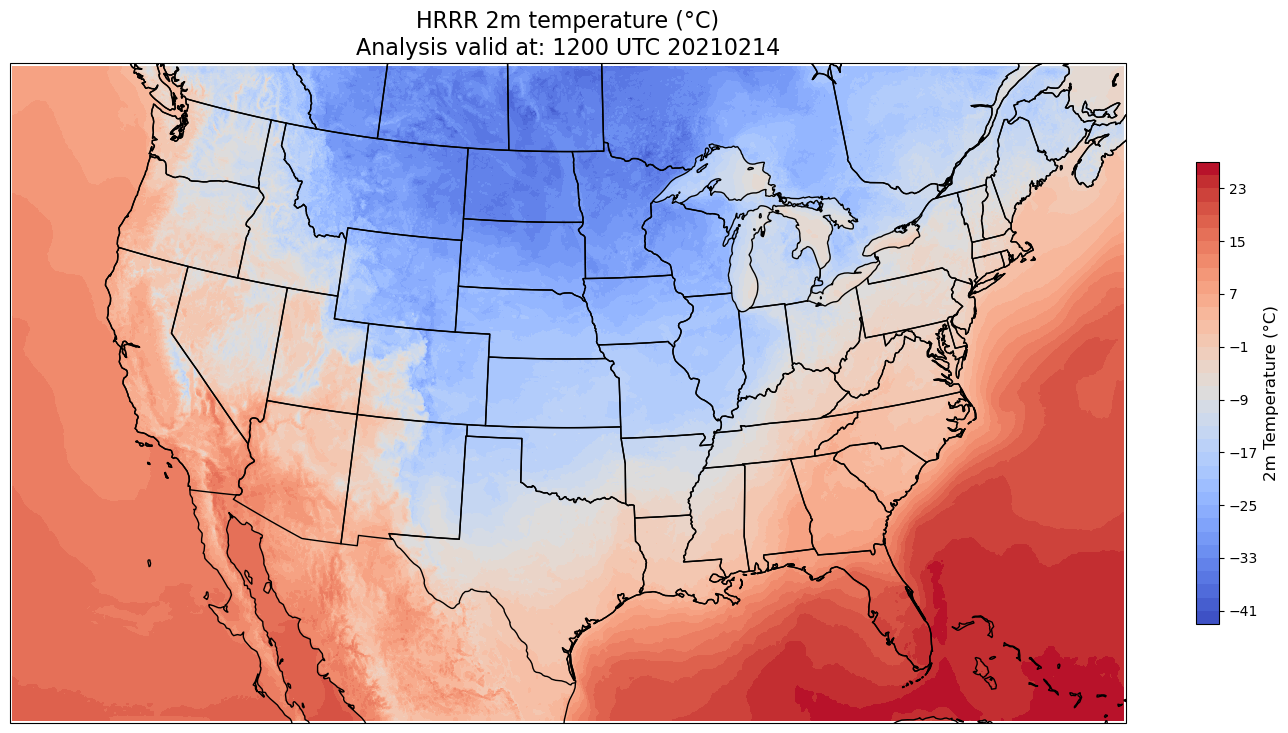

In [20]:
latN = 50.4
latS = 24.25
lonW = -123.8
lonE = -71.2

res = '50m'

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1,1,1,projection=projData)
ax.set_extent ([lonW,lonE,latS,latN],crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))

# Add the title
tl1 = 'HRRR 2m temperature (°C)'
tl2 = f'Analysis valid at: {hour}00 UTC {date}'  
ax.set_title(f'{tl1}\n{tl2}',fontsize=16)
# Contour fill
CF = ax.contourf(x,y,airTemp,levels=fint,cmap=plt.get_cmap('coolwarm'))
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CF,shrink=0.5)
cbar.set_label(f'2m Temperature (°C)', size='large')

## Conclusions

We've demonstrated the following concept in this workbook:
- Use `Zarr` to efficiently store chunked, multidimensional gridded spatial data
- Access and load archived NCEP HRRR data hosted on AWS in `Zarr` format from cloud-based object store system such as AWS S3
- Quick side trip on using `dask` as a way to efficiently split operations on chunked data
- Visualize HRRR temperature data and plot maps

## Additional Resources
- [HRRR in Zarr format](https://mesowest.utah.edu/html/hrrr/)
- [NCEP's HRRR S3 archive (GRIB format)](https://registry.opendata.aws/noaa-hrrr-pds/)
- [What is *object store*?](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html)
- [Xarray's Dask implementation](http://xarray.pydata.org/en/stable/user-guide/dask.html)
- [AWS Skill Builder](https://skillbuilder.aws/): This training portal provided by AWS contains self-paced training modules for all of AWS' cloud storage and compute services. While many of the courses are behind a paywall, many of the introductory courses are free to access. Use the web application's filtering function to focus your search, for example to [`Free` courses of the `Fundamental` skill level focused on `Data analytics`](https://skillbuilder.aws/category/domain/data-analytics?page=1&accessTier=free&courseLevel=fundamental)